# Plot of the Week — Plot 2: Confusion Matrix (Heatmap)

**STAT-UN3106**

**Goal:** Build and interpret a confusion matrix for a classifier, and explore how *error structure*, *class imbalance*, and metrics *beyond accuracy* change what you learn.

---

## What you’ll submit
Upload **one** of the following:
- the figure (**PNG or PDF**) **OR**
- the notebook cell output (screenshot / exported output)

Plus a **short caption (1–2 sentences)**.

### Required submission template
**Title:**  
**What question does this plot answer?**  

**Description (1–2 sentences):**  
**What data / model / comparison is shown?**


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, balanced_accuracy_score, accuracy_score


## 1) Data: Handwritten digits (multi-class classification)

We'll use the **Digits** dataset (0–9). Each example is an 8×8 grayscale image flattened into 64 features.


In [2]:
# Load data
digits = load_digits()
X = digits.data
y = digits.target
class_names = [str(i) for i in digits.target_names]

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

X_train.shape, X_test.shape


((1347, 64), (450, 64))

## 2) Baseline model: Logistic Regression (multinomial)

We’ll fit a simple classifier. The notebook **provides the data + model code**.  
You will have a **student section** later where changing one thing changes the plot output.


In [5]:
# A standard baseline pipeline: scaling + logistic regression
clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        C=1.0,
        n_jobs=None
    ))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))


Accuracy: 0.9688888888888889
Balanced accuracy: 0.9686181838608533


## 3) Evaluation beyond accuracy (what the confusion matrix reveals)

Accuracy can hide problems:
- If one class dominates, a model can get high accuracy by predicting the majority class.
- Confusion matrices show *which* mistakes happen (e.g., always confusing class A with B).

**Interpretation tip:**  
- Diagonal = correct predictions  
- Off-diagonal = specific types of errors (**error structure**)  


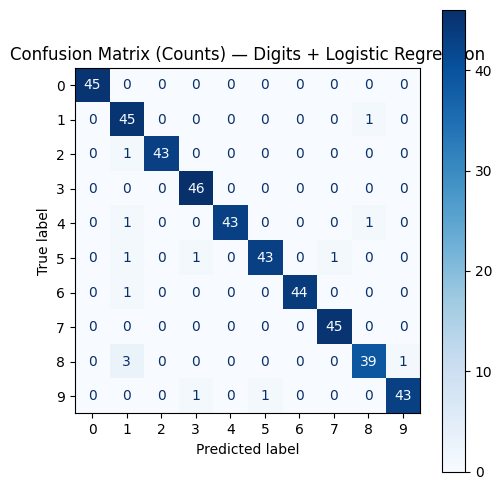

In [6]:
# Confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")

ax.set_title("Confusion Matrix (Counts) — Digits + Logistic Regression")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.tight_layout()
plt.show()


# Student Section

This section intentionally creates a **highly imbalanced** training set (while keeping the test set unchanged).
Your goal is to **improve performance on the rare classes**.

### Your task
1. **Turn on imbalance** (`MAKE_IMBALANCE = True`) and observe how the confusion matrix degrades.
2. Improve the model by changing **at least TWO** hyperparameters below (not just `C`).
   - Recommended knobs: `class_weight`, `penalty`, `solver`, `max_iter`, `C`
3. Report and compare the confusion matrix

**Hint:** Accuracy can stay high even when minority classes collapse. Macro-F1 and balanced accuracy will reveal that.


In [61]:
# 1) Create strong class imbalance in the TRAINING data (test set stays balanced)
MAKE_IMBALANCE = True

# Keep only a tiny fraction of several classes in training.
# Fractions should be in (0, 1]. 1.0 means keep all.
DOWNSAMPLE_FRACTIONS = {
    1: 0.05,
    7: 0.05,
    9: 0.05,
    8: 0.10,
}

# 2) Model hyperparameters (you must change at least TWO of these)
C_TWEAK = 1.0

# Try: None, "balanced", or a dict like {0: 1.0, 1: 10.0, ...}
CLASS_WEIGHT = None

# Try: "l2" (default), "l1" (requires solver="saga"), "elasticnet" (requires solver="saga" + l1_ratio)
PENALTY = "l2"
SOLVER = "lbfgs"
MAX_ITER = 2000
L1_RATIO = 0.5       # only used if PENALTY="elasticnet"

# Plot settings
CMAP = "Blues"
FIGSIZE = (6, 6)
RANDOM_SEED = 0


Training set size after imbalance: 842
Class counts in training: {np.int64(0): np.int64(133), np.int64(1): np.int64(6), np.int64(2): np.int64(133), np.int64(3): np.int64(137), np.int64(4): np.int64(136), np.int64(5): np.int64(136), np.int64(6): np.int64(136), np.int64(7): np.int64(6), np.int64(8): np.int64(13), np.int64(9): np.int64(6)}
Accuracy:          0.8800
Balanced accuracy: 0.8799
Macro-F1:          0.8744


/Users/jalenstephens/Dev/Applied-ML-HW/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


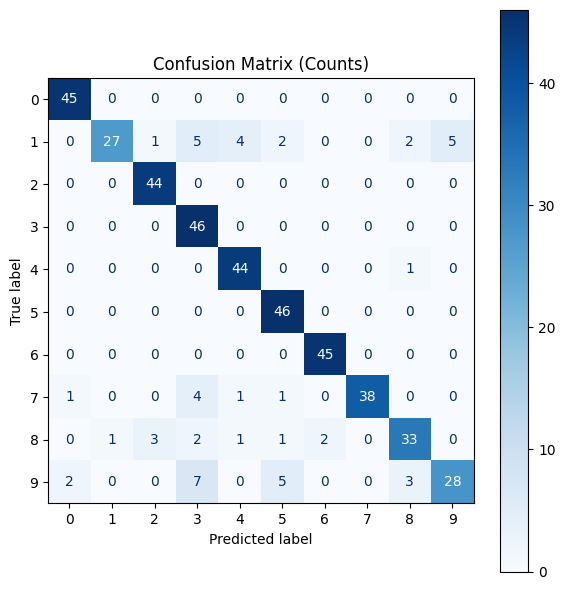

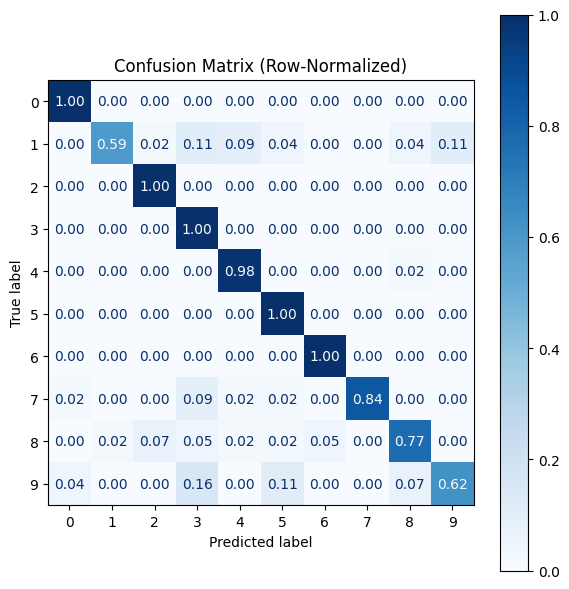

In [62]:
from sklearn.metrics import balanced_accuracy_score, f1_score

# Apply class imbalance (training only), then refit model and plot confusion matrix

X_tr = X_train.copy()
y_tr = y_train.copy()

if MAKE_IMBALANCE:
    rng = np.random.default_rng(RANDOM_SEED)

    keep_mask = np.ones(len(y_tr), dtype=bool)

    for cls, frac in DOWNSAMPLE_FRACTIONS.items():
        cls_idx = np.where(y_tr == cls)[0]
        if len(cls_idx) == 0:
            continue
        n_keep = max(1, int(np.floor(frac * len(cls_idx))))
        keep_idx = rng.choice(cls_idx, size=n_keep, replace=False)

        # drop the rest of this class
        drop_idx = np.setdiff1d(cls_idx, keep_idx, assume_unique=False)
        keep_mask[drop_idx] = False

    X_tr = X_tr[keep_mask]
    y_tr = y_tr[keep_mask]

print("Training set size after imbalance:", len(y_tr))
print("Class counts in training:", dict(zip(*np.unique(y_tr, return_counts=True))))

# Build the tweaked model
model_kwargs = dict(
    max_iter=MAX_ITER,
    solver=SOLVER,
    C=C_TWEAK,
    class_weight=CLASS_WEIGHT,
)

# Only set penalty / l1_ratio if the solver supports it (students can experiment)
model_kwargs["penalty"] = PENALTY
if PENALTY == "elasticnet":
    model_kwargs["l1_ratio"] = L1_RATIO

clf_tweaked = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(**model_kwargs))
])

clf_tweaked.fit(X_tr, y_tr)
y_pred_t = clf_tweaked.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred_t)
bacc = balanced_accuracy_score(y_test, y_pred_t)
mf1 = f1_score(y_test, y_pred_t, average="macro")

print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bacc:.4f}")
print(f"Macro-F1:          {mf1:.4f}")

# Confusion matrix (counts)
cm_t = confusion_matrix(y_test, y_pred_t, labels=np.arange(len(class_names)))

fig, ax = plt.subplots(figsize=FIGSIZE)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=class_names)
disp.plot(ax=ax, cmap=CMAP, colorbar=True, values_format="d")
ax.set_title("Confusion Matrix (Counts)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.tight_layout()
plt.show()

# Optional: normalized confusion matrix (row-normalized)
cm_norm = cm_t.astype(float) / cm_t.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=FIGSIZE)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp.plot(ax=ax, cmap=CMAP, colorbar=True, values_format=".2f")
ax.set_title("Confusion Matrix (Row-Normalized)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.tight_layout()
plt.show()


Training set size after imbalance: 842
Class counts in training: {np.int64(0): np.int64(133), np.int64(1): np.int64(6), np.int64(2): np.int64(133), np.int64(3): np.int64(137), np.int64(4): np.int64(136), np.int64(5): np.int64(136), np.int64(6): np.int64(136), np.int64(7): np.int64(6), np.int64(8): np.int64(13), np.int64(9): np.int64(6)}


/Users/jalenstephens/Dev/Applied-ML-HW/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/jalenstephens/Dev/Applied-ML-HW/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


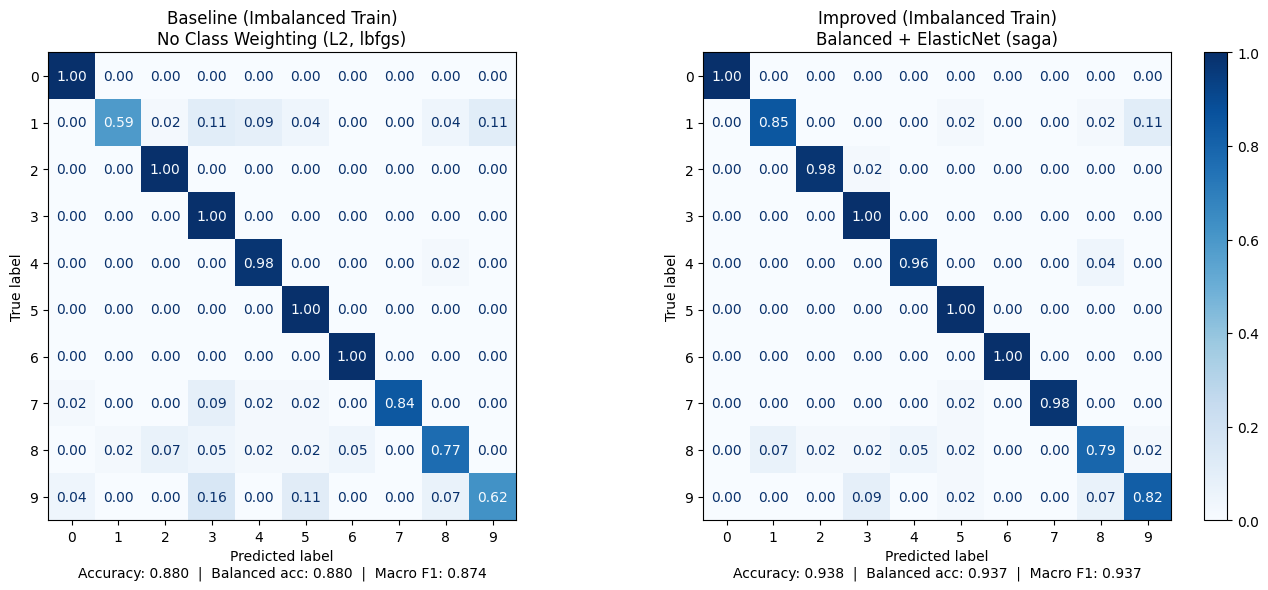

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, f1_score

# -----------------------------
# 1) Create strong class imbalance in the TRAINING data (test set stays balanced)
# -----------------------------
MAKE_IMBALANCE = True

DOWNSAMPLE_FRACTIONS = {
    1: 0.05,
    7: 0.05,
    9: 0.05,
    8: 0.10,
}

RANDOM_SEED = 0
CMAP = "Blues"
FIGSIZE = (14, 6)  # wider for side-by-side

X_tr = X_train.copy()
y_tr = y_train.copy()

if MAKE_IMBALANCE:
    rng = np.random.default_rng(RANDOM_SEED)
    keep_mask = np.ones(len(y_tr), dtype=bool)

    for cls, frac in DOWNSAMPLE_FRACTIONS.items():
        cls_idx = np.where(y_tr == cls)[0]
        if len(cls_idx) == 0:
            continue
        n_keep = max(1, int(np.floor(frac * len(cls_idx))))
        keep_idx = rng.choice(cls_idx, size=n_keep, replace=False)

        drop_idx = np.setdiff1d(cls_idx, keep_idx, assume_unique=False)
        keep_mask[drop_idx] = False

    X_tr = X_tr[keep_mask]
    y_tr = y_tr[keep_mask]

print("Training set size after imbalance:", len(y_tr))
print("Class counts in training:", dict(zip(*np.unique(y_tr, return_counts=True))))

# -----------------------------
# 2) Helper: fit model + compute row-normalized CM
# -----------------------------
def fit_and_cm_norm(model_kwargs):
    clf = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(**model_kwargs))
    ])
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    mf1 = f1_score(y_test, y_pred, average="macro")
    return cm_norm, acc, bacc, mf1

# -----------------------------
# 3) Baseline (matches your ORIGINAL settings)
# -----------------------------
baseline_kwargs = dict(
    max_iter=2000,
    solver="lbfgs",
    C=1.0,
    class_weight=None,
    penalty="l2",
)

# -----------------------------
# 4) Improved (your best settings)
# -----------------------------
improved_kwargs = dict(
    max_iter=2000,
    solver="saga",
    C=0.8,
    class_weight="balanced",
    penalty="elasticnet",
    l1_ratio=0.7,
)

cm_base_norm, acc_base, bacc_base, mf1_base = fit_and_cm_norm(baseline_kwargs)
cm_impr_norm, acc_impr, bacc_impr, mf1_impr = fit_and_cm_norm(improved_kwargs)

# -----------------------------
# 5) Plot row-normalized side-by-side
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)

disp0 = ConfusionMatrixDisplay(confusion_matrix=cm_base_norm, display_labels=class_names)
disp0.plot(ax=axes[0], cmap=CMAP, colorbar=False, values_format=".2f")
axes[0].set_title("Baseline (Imbalanced Train)\nNo Class Weighting (L2, lbfgs)")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")
axes[0].text(0.5, -0.12, f"Accuracy: {acc_base:.3f}  |  Balanced acc: {bacc_base:.3f}  |  Macro F1: {mf1_base:.3f}", transform=axes[0].transAxes, ha="center", fontsize=10)

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_impr_norm, display_labels=class_names)
disp1.plot(ax=axes[1], cmap=CMAP, colorbar=True, values_format=".2f")
axes[1].set_title("Improved (Imbalanced Train)\nBalanced + ElasticNet (saga)")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")
axes[1].text(0.5, -0.12, f"Accuracy: {acc_impr:.3f}  |  Balanced acc: {bacc_impr:.3f}  |  Macro F1: {mf1_impr:.3f}", transform=axes[1].transAxes, ha="center", fontsize=10)

plt.tight_layout()
plt.show()
